# Per-state LSTM classification model ensemble

## Notebook set-up

In [1]:
# Standard library imports
import os
import multiprocessing as mp

# PyPI imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, roc_curve, precision_recall_curve

# Internal imports
import perdrizet_helper_funcs

# Set GPU for TensorFlow
os.environ['CUDA_VISIBLE_DEVICES']='1'

# Set multiprocessing start method to allow CUDA use in the workers
mp.set_start_method('spawn')

# Input data
data_file='../data/resampled_disaster_data_all.parquet'

# Incident feature to use
incident_feature='linear_log_incidents'

# Training details
model_type='classification'
include_synthetic_features=False
retrain_ensemble=True
window=18
num_training_workers=5
training_epochs=100
learning_rate=0.001
l1_weight=0.001
l2_weight=0.01

## 1. Data loading

In [2]:
raw_data_df=pd.read_parquet(data_file)

# Grab the features we are interested in
data_df=raw_data_df[['month_cos', 'month_sin', 'incidents_binary', incident_feature]].copy()

# Transfer the index
data_df.set_index(raw_data_df.index)

# Save the index of the target column
target_column_index=data_df.columns.get_loc(incident_feature)
data_df.head()

# Save the index of the target column
target_column_index=data_df.columns.get_loc('incidents_binary')

# Get and show some summary statistics
total_disaster_months=len(data_df[data_df['incidents_binary'] != 0])
percent_disaster_months=(total_disaster_months/len(data_df)) * 100
print(f'Have {total_disaster_months}({percent_disaster_months:.1f}%) disaster months\n')

data_df.info()

Have 2265(6.0%) disaster months

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 37622 entries, (1953, 5, 'LA') to (2020, 9, 'UT')
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   month_cos             37622 non-null  float64
 1   month_sin             37622 non-null  float64
 2   incidents_binary      37622 non-null  int64  
 3   linear_log_incidents  37622 non-null  float64
dtypes: float64(3), int64(1)
memory usage: 1.3+ MB


In [3]:
data_df.describe()

,month_cos,month_sin,incidents_binary,linear_log_incidents
count,3.762200e+04,3.762200e+04,37622.000000,37622.000000
mean,-4.561229e-04,-7.174095e-04,0.060204,0.050032
std,7.072053e-01,7.070265e-01,0.237868,0.224275
min,-1.000000e+00,-1.000000e+00,0.000000,0.000000
25%,-8.660254e-01,-8.660254e-01,0.000000,0.000000
50%,-1.836970e-16,-2.449294e-16,0.000000,0.000000
75%,5.000000e-01,5.000000e-01,0.000000,0.000000
max,1.000000e+00,1.000000e+00,1.000000,2.415211


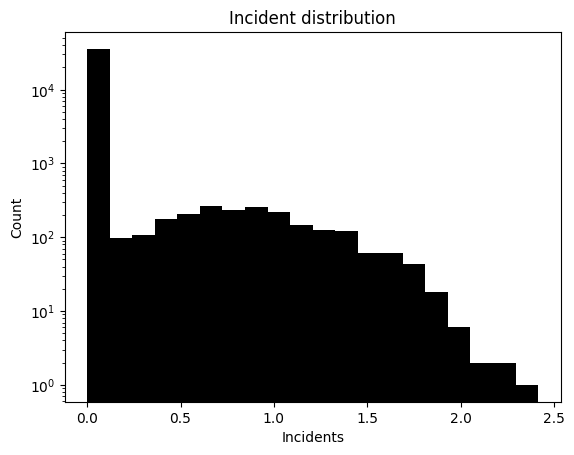

In [4]:
# Draw a quick plot to check the distribution of disaster counts
plt.title('Incident distribution')
plt.hist(data_df[incident_feature], bins=20, color='black')
plt.xlabel('Incidents')
plt.ylabel('Count')
plt.yscale('log')
plt.savefig('./figures/5.1-1-classification_state_LSTM_incident_distribution.jpg')
plt.show()

## 2. Train-test split

Take the most recent ~10% of the data for testing.

In [5]:
# Get list of years
years=data_df.index.get_level_values('year').unique().tolist()
testing_years=len(years) // 10
print(f'Using most recent {testing_years} of {len(years)} years for test set')
print(f'Testing years: {years[-testing_years:]}')
print(f'Training years: {years[:-testing_years]}')

# Take last n years for testing data
testing_df=data_df.loc[years[-testing_years:]]

# Take the rest for training
training_df=data_df.loc[years[:-testing_years]]

# Check result
training_df.head()

Using most recent 7 of 71 years for test set
Testing years: [2017, 2018, 2019, 2020, 2021, 2022, 2023]
Training years: [1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016]


month_cos     month_sin  incidents_binary  \
year month state                                                 
1953 5     LA    -8.660254e-01  5.000000e-01                 1   
     6     LA    -1.000000e+00  1.224647e-16                 0   
     7     LA    -8.660254e-01 -5.000000e-01                 0   
     8     LA    -5.000000e-01 -8.660254e-01                 0   
     9     LA    -1.836970e-16 -1.000000e+00                 0   

                  linear_log_incidents  
year month state                        
1953 5     LA                 1.237322  
     6     LA                 0.000000  
     7     LA                 0.000000  
     8     LA                 0.000000  
     9     LA                 0.000000

## 3. Data formatting & training-validation splitting

In [6]:
# Run custom splitting function
training_features, training_labels, validation_features, validation_labels, states=perdrizet_helper_funcs.make_windowed_time_course(training_df, target_column_index, window)

# Check the result
print(f'States: {len(training_features)}')

for state, features, labels in zip(states, training_features, training_labels):
    print(f'{state}: features: {features.shape}, labels: {labels.shape}')

States: 50
LA: features: (515, 18, 4), labels: (515, 1)
MT: features: (515, 18, 4), labels: (515, 1)
TX: features: (515, 18, 4), labels: (515, 1)
IA: features: (515, 18, 4), labels: (515, 1)
FL: features: (512, 18, 4), labels: (512, 1)
CA: features: (509, 18, 4), labels: (509, 1)
SD: features: (506, 18, 4), labels: (506, 1)
WV: features: (505, 18, 4), labels: (505, 1)
ME: features: (504, 18, 4), labels: (504, 1)
MA: features: (504, 18, 4), labels: (504, 1)
CT: features: (504, 18, 4), labels: (504, 1)
RI: features: (504, 18, 4), labels: (504, 1)
SC: features: (503, 18, 4), labels: (503, 1)
NY: features: (503, 18, 4), labels: (503, 1)
IN: features: (503, 18, 4), labels: (503, 1)
NM: features: (503, 18, 4), labels: (503, 1)
NC: features: (503, 18, 4), labels: (503, 1)
CO: features: (485, 18, 4), labels: (485, 1)
NV: features: (498, 18, 4), labels: (498, 1)
OK: features: (498, 18, 4), labels: (498, 1)
NJ: features: (496, 18, 4), labels: (496, 1)
PA: features: (496, 18, 4), labels: (496, 1)

## 4. Model training

### 4.1. Set-up and build models

In [7]:
if retrain_ensemble:
    
    model_builder=mp.Process(
        target=perdrizet_helper_funcs.make_state_models,
        args=(
            states,
            training_features,
            learning_rate,
            l1_weight,
            l2_weight,
            'classification'
        ))

    model_builder.start()
    model_builder.join()

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'): set_memory_growth==True
Compiling LSTM for state ensemble with L1=0.001, L2=0.01
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 LSTM (LSTM)                 (None, 512)               1058816   
                                                                 
 dense.1 (Dense)             (None, 256)               131328    
                                                                 
 dense.2 (Dense)             (None, 128)               32896     
                                                                 
 dense.3 (Dense)             (None, 32)                4128      
                                                                 
 classification_output (Dens  (None, 1)                33        
 e)                                                              
                                         

### 4.2. Train the model ensemble

In [8]:
def run_training_workers(n: int):
    '''Runs n training workers to train each state model.'''

    # Set-up multiprocessing queues for input to workers
    mp_manager=mp.Manager()
    input_queue=mp_manager.Queue(-1)

    # Set-up training worker processes
    training_workers=[]
    for _ in range(n):
        training_workers.append(
            mp.Process(
                target=perdrizet_helper_funcs.state_training_run,
                args=(
                    input_queue,
                    training_epochs
                )
            )
        )

    # Start the training workers
    for worker in training_workers:
        worker.start()

    # Put the work in the input queue
    for i in range(len(training_features)):

        # Build the workunit
        workunit={
            'status': 'Work',
            'state': states[i],
            'training_features': training_features[i],
            'training_labels': training_labels[i],
            'validation_features': validation_features[i],
            'validation_labels': validation_labels[i]
        }

        # Submit the workunit
        input_queue.put(workunit)

    # Send a stop signal for each worker
    for _ in range(n):
        input_queue.put({'status': 'Done'})

    # Join and then close each score training process
    for worker in training_workers:
        worker.join()
        worker.close()

In [9]:
%%time

if retrain_ensemble:
    run_training_workers(num_training_workers)

CPU times: user 64.2 ms, sys: 56.3 ms, total: 121 ms
Wall time: 18min 22s


### 4.2. Plot training curves

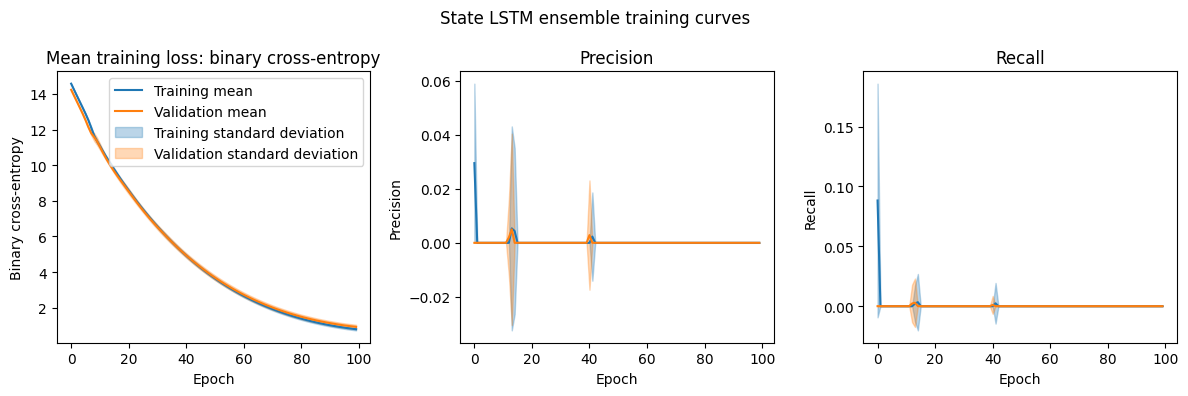

In [10]:
plot=perdrizet_helper_funcs.plot_ensemble_training_run(states)
plot.savefig('./figures/5.1-4.2-classification_state_LSTM_ensemble_training_curves.jpg')
plot.show()

## 5. Model evaluation

### 5.1. Make predictions on test set

#### 5.1.1. Format testing data for prediction

In [12]:
testing_features=[]
testing_labels=[]

states=testing_df.index.get_level_values('state').unique().tolist()

for state in states:

    state_df=testing_df.loc[:,:,(state)].copy()

    if len(state_df) > window + 1:

        state_testing_features=[]
        state_testing_labels=[]

        for i in range(len(state_df) - window -  1):

            state_testing_features.append(state_df.iloc[i:i + window])
            state_testing_labels.append([state_df.iloc[window + i + 1]['incidents_binary']])

        testing_features.append(np.array(state_testing_features))
        testing_labels.append(np.array(state_testing_labels))

# Check the result
for state, features, labels in zip(states, testing_features, testing_labels):
    print(f'{state}: features: {features.shape}, labels: {labels.shape}')

LA: features: (38, 18, 4), labels: (38, 1)
MT: features: (47, 18, 4), labels: (47, 1)
TX: features: (31, 18, 4), labels: (31, 1)
IA: features: (41, 18, 4), labels: (41, 1)
FL: features: (52, 18, 4), labels: (52, 1)
CA: features: (56, 18, 4), labels: (56, 1)
SD: features: (47, 18, 4), labels: (47, 1)
WV: features: (49, 18, 4), labels: (49, 1)
ME: features: (53, 18, 4), labels: (53, 1)
MA: features: (42, 18, 4), labels: (42, 1)
CT: features: (38, 18, 4), labels: (38, 1)
RI: features: (42, 18, 4), labels: (42, 1)
SC: features: (50, 18, 4), labels: (50, 1)
NY: features: (53, 18, 4), labels: (53, 1)
IN: features: (50, 18, 4), labels: (50, 1)
NM: features: (53, 18, 4), labels: (53, 1)
NC: features: (38, 18, 4), labels: (38, 1)
NV: features: (37, 18, 4), labels: (37, 1)
OK: features: (31, 18, 4), labels: (31, 1)
NJ: features: (52, 18, 4), labels: (52, 1)
PA: features: (30, 18, 4), labels: (30, 1)
OR: features: (50, 18, 4), labels: (50, 1)
WA: features: (48, 18, 4), labels: (48, 1)
ID: feature

#### 5.1.2. Make predictions for each state

In [13]:
with mp.Manager() as manager:
    results=manager.list()

    for state, state_features, in zip(states, testing_features):
        print(f'Making predictions for {state} testing data.')
        inference_worker=mp.Process(
            target=perdrizet_helper_funcs.make_state_predictions,
            args=(
                state,
                state_features,
                results
            )
        )

        inference_worker.start()
        inference_worker.join()

    # Collect the results back into a python list
    predictions=list(results)

Making predictions for LA testing data.
Making predictions for MT testing data.
Making predictions for TX testing data.
Making predictions for IA testing data.
Making predictions for FL testing data.
Making predictions for CA testing data.
Making predictions for SD testing data.
Making predictions for WV testing data.
Making predictions for ME testing data.
Making predictions for MA testing data.
Making predictions for CT testing data.
Making predictions for RI testing data.
Making predictions for SC testing data.
Making predictions for NY testing data.
Making predictions for IN testing data.
Making predictions for NM testing data.
Making predictions for NC testing data.
Making predictions for NV testing data.
Making predictions for OK testing data.
Making predictions for NJ testing data.
Making predictions for PA testing data.
Making predictions for OR testing data.
Making predictions for WA testing data.
Making predictions for ID testing data.
Making predictions for PR testing data.


#### 5.1.2. Combine and format predictions

In [14]:
prediction_dfs=[]

for state, state_predictions, state_labels in zip(states, predictions, testing_labels):
    prediction_df=pd.DataFrame.from_dict(
        {
            'labels': np.array(state_labels).flatten(),
            'probabilities': np.array(state_predictions).flatten()
        }
    )
    prediction_df['state']=[state]*len(prediction_df)
    prediction_dfs.append(prediction_df)

predictions_df=pd.concat(prediction_dfs)
predictions_df.head()

,labels,probabilities,state
0,0.0,0.077043,LA
1,0.0,0.076991,LA
2,0.0,0.076947,LA
3,0.0,0.076922,LA
4,0.0,0.076922,LA


### 5.2. Distribution of predicted incident probabilities

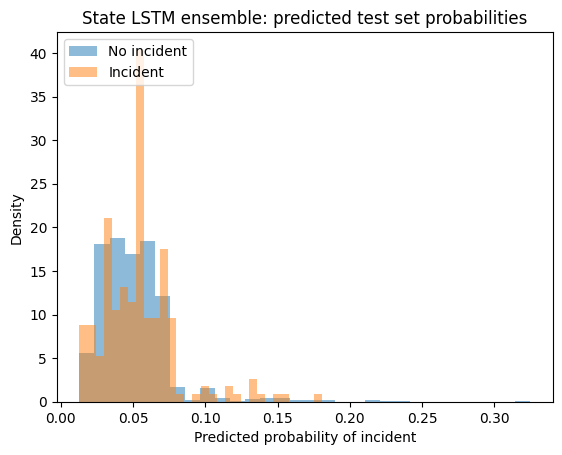

In [15]:
plt.title('State LSTM ensemble: predicted test set probabilities')
plt.hist(predictions_df['probabilities'][predictions_df['labels'] == 0], bins=30, density=True, alpha=0.5, label='No incident')
plt.hist(predictions_df['probabilities'][predictions_df['labels'] == 1], bins=30, density=True, alpha=0.5, label='Incident')
plt.xlabel('Predicted probability of incident')
plt.ylabel('Density')
plt.legend(loc='upper left')
plt.savefig('./figures/5.1-5.2-classification_state_LSTM_ensemble_predicted_probability_distributions.jpg')
plt.show()

### 5.3. Receiver-operator characteristic and precision-recall curves

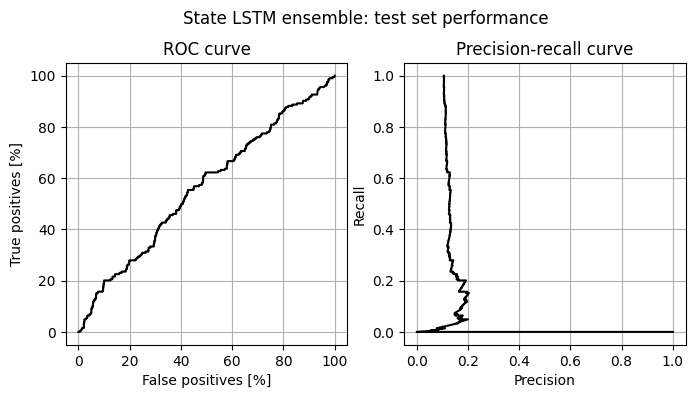

In [16]:
# Set-up a 1x2 figure
fig, axs=plt.subplots(1,2, figsize=(8,4))

# Add the main title
fig.suptitle('State LSTM ensemble: test set performance', size='large')

# Plot ROC curve
fp, tp, _=roc_curve(predictions_df['labels'], predictions_df['probabilities'])
axs[0].set_title('ROC curve')
axs[0].plot(100*fp, 100*tp, color='black')
axs[0].set_xlabel('False positives [%]')
axs[0].set_ylabel('True positives [%]')
axs[0].grid(True)
axs[0].set_aspect('equal')

# Plot PR curve
precision, recall, _=precision_recall_curve(predictions_df['labels'], predictions_df['probabilities'])
axs[1].set_title('Precision-recall curve')
axs[1].plot(precision, recall, color='black')
axs[1].set_xlabel('Precision')
axs[1].set_ylabel('Recall')
axs[1].grid(True)
axs[1].set_aspect('equal')

plt.savefig('./figures/5.1-5.3-classification_state_LSTM_ensemble_ROC_PR_curves.jpg')
plt.show()

### 5.4. Confusion matrix

/mnt/arkk/4geeks_repos/29-ds7-final_projects/gperdrizet_natural_disasters/.venv-GPU/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision: 0.000
Recall: 0.000



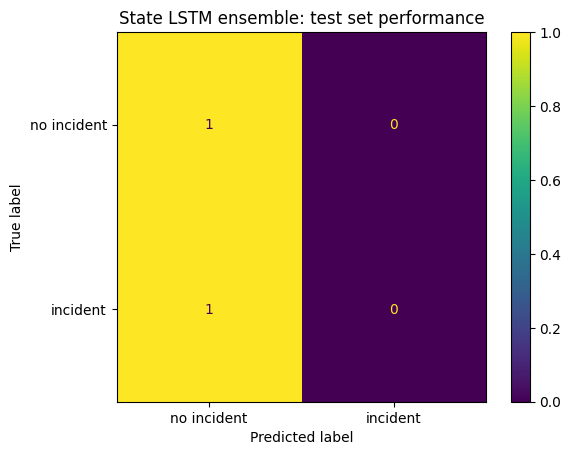

In [17]:
# Set threshold and call incidents
threshold=0.5
calls=np.where(predictions_df['probabilities'] > threshold, 1, 0)

# Calculate precision and recall
precision=precision_score(predictions_df['labels'], calls)
recall=recall_score(predictions_df['labels'], calls)
print(f'Precision: {precision:.3f}')
print(f'Recall: {recall:.3f}\n')

# Plot the confusion matrix
cm=confusion_matrix(predictions_df['labels'], calls, normalize='true')
cm_disp=ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['no incident', 'incident'])
_=cm_disp.plot()
plt.title('State LSTM ensemble: test set performance')
plt.savefig('./figures/5.1-5.4-classification_state_LSTM_ensemble_confusion_matrix.jpg')
plt.show()